## Task 1 Image Classification

For the first part of this lab, we are going to learn how to perform image classification. Using deep learning networks to perform image classification is a popular task. A dataset comprised of paintings from Van Gogh and other artists will be used to create a binary classifier.

For this part of the lab, we are going to use a [kaggle](https://www.kaggle.com) dataset of paintings used to identify [Van Gogh's work](https://www.kaggle.com/gfolego/vangogh) [1]. The dataset has already been downloaded. First, we are going to explore the data and view some of the images in the dataset.


In [1]:
#import modules we plan to use
#-*- coding: utf-8 -*-
%matplotlib inline
import csv
from PIL import Image
import numpy as np
import tensorflow as tf
import skimage.io as io
import matplotlib.pyplot as plt
import scipy.ndimage
!nvidia-smi

Wed May 10 21:32:19 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.57                 Driver Version: 367.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   55C    P8    27W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#Read a text file with a list of the training and validation images
TRAIN_LIST=[]
with open('/data/vgdb_2016/train.txt') as csvfile:
        train_list=csv.reader(csvfile)
        for row in train_list:
                TRAIN_LIST+=row
                
img_list=TRAIN_LIST[0::2]
label_list=TRAIN_LIST[1::2]

TEST_LIST=[]
with open('/data/vgdb_2016/test.txt') as csvfile:
        test_list=csv.reader(csvfile)
        for row in test_list:
                TEST_LIST+=row
                
test_img_list=TEST_LIST[0::2]
test_label_list=TEST_LIST[1::2]

index 38
Not Van Gogh Painting


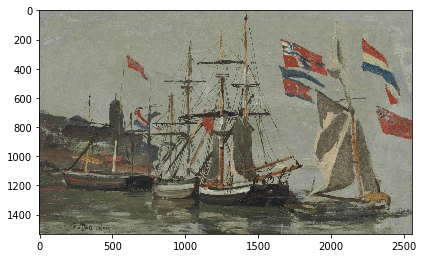

In [3]:
#View and image from our Dataset
from random import randint
SampleImageIndex=randint(0,len(img_list)) #select a random image from the training set
sample_image=io.imread(img_list[SampleImageIndex])
io.imshow(sample_image)
print("index "+str(SampleImageIndex))
if label_list[SampleImageIndex]== str(0):
    print("Not Van Gogh Painting")
else:
    print("Van Gogh Painting")

There is more than one way to ingest data into TensorFlow. Three approaches are described in the [documentation](https://www.tensorflow.org/programmers_guide/reading_data). For this part of the lab, we are going to create a TensorFlow record of our data set. We are doing this because in some cases you may find that creating a binary is easier to use. A blog by [Daniil Pakhomov](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/) was used to create this portion of the lab.

In the cell below, create a name for your first TensorFlow record file. If you need help you can find a hint [here](#answer1 "Your first tfrecord can be anything you want. Remember this needs to be a string. For example -- tfrecord_filename='vg_classification.tfrecords'").

Please note that creating this tfrecord file may take 5 minutes to complete.

In [4]:
def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#Provide a name for your tfrecord file such as 'my_first.tfrecords'
tfrecord_filename='my_first.tfrecords'

test_tfrecord_filename='/data/vgdb_2016/test_classification.tfrecords'

In [5]:

writer=tf.python_io.TFRecordWriter(tfrecord_filename)

original_images=[]

for img_path,object_class in zip(img_list,label_list):
  
        img2record=scipy.ndimage.imread(img_path)
        height,width,colorbands=img2record.shape
        original_images.append(img2record)
        img_raw = img2record.astype("uint8")

        img_raw=img_raw.tostring()
        example=tf.train.Example(features=tf.train.Features(feature={
                'height':_int64_feature(height),
                'width':_int64_feature(width),
                'depth':_int64_feature(colorbands),
                'label':_int64_feature(int(object_class)),
                'image_raw':_bytes_feature(img_raw)}))
        writer.write(example.SerializeToString())

writer.close()

print('finished creating tfrecord')

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (178946307 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


finished creating tfrecord


In this next step, we are reading the TensorFlow record file and reconstructing the image to confirm that we have done it properly.

In [6]:
#Attempt to reconstruct the images from the tfrecordfile
reconstructed_images = []
out_classes=[]
record_iterator = tf.python_io.tf_record_iterator(path=tfrecord_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    depth = int(example.features.feature['depth']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    labels = (example.features.feature['label']
                                .int64_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    reconstructed_images.append((reconstructed_img))
    out_classes.append((labels))

In [7]:
# Let's check if the first 5 reconstructed images match
#True == same 
NumOfImagesEval=5

for i in range(NumOfImagesEval): 
    print(sum(sum(sum(reconstructed_images[i]-original_images[i])))==0)

True
True
True
True
True


The images in the original image (img_list) and reconstructed list (recontstrcuted_images) are the same. To compare  one of the originals with a reconstructed one we can use the index of the element we are interested in. Use the index of an image from the training data set to visually compare the original with the reconstructed. There are 264 images in the training set. Go here if you would like a [hint](#answer2 "You may choose any value between 0 and 263, the number of images in our training dataset. For example TRAINING_IMAGE=0 can you used.").

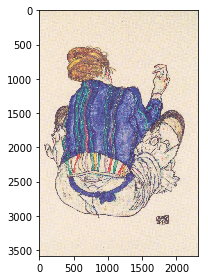

In [8]:
#Let's look at a reconstructed image. This can be done by selecting the index of a image you would like to view
#such as image 0
TRAINING_IMAGE=0
reconstructed_images[TRAINING_IMAGE].shape
io.imshow(reconstructed_images[TRAINING_IMAGE])

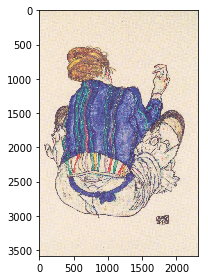

In [9]:
orig_image=io.imread(img_list[TRAINING_IMAGE])
io.imshow(orig_image)

Did it work? Were you able to view the reconstructed images?

Next, we are going preprocess our data from the TensorFlow record file and create batches for training. What should the outputs be for this function? What variables in read_and_decode to you want to feed into a neural network? 

You can look [here](#answer3 "return shuffled_img, shuffled_label") for a hint.

In [10]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
BATCH_SIZE = 32
NUM_CLASSES=2
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN=264#len(img_list)
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'depth': tf.FixedLenFeature([], tf.int64), 
        'label':tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor to a uint8 tensor 
    
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['label'], tf.int32)
    image_shape = tf.stack([height, width, 3])
    #image.set_shape(image_shape)
    
    image = tf.reshape(image, image_shape)     
         
    #Randomly cropping image
    random_crop_image=tf.random_crop(image, size=[IMAGE_HEIGHT,IMAGE_WIDTH,3], seed=None, name=None)

    min_after_dequeue = 500
    capacity = min_after_dequeue + 3 * BATCH_SIZE 
    shuffled_img, shuffled_label = tf.train.shuffle_batch([random_crop_image, label],
                                                 batch_size=BATCH_SIZE ,
                                                 capacity=capacity,
                                                 num_threads=4,
                                                 min_after_dequeue=min_after_dequeue)
    
    return shuffled_img, shuffled_label

The next cell contains the CNN we are going to use. For this example, we are applying the CIFAR network. This network is comprised of convolutional, pooling, normalization, ReLU activation, and fully connected layers. There is more than one place to view examples of this CNN, including the [TensorFlow documentation](https://www.tensorflow.org/tutorials/deep_cnn) as well as [Caffe](http://caffe.berkeleyvision.org/gathered/examples/cifar10.html).

For the model function below, cnn_model, what should the output be? 

Need a hint? Look [here](#answer4 "The output of this function should be softmax_linear").

In [11]:
def cnn_model(img):
    #CIFAR10 Network
    conv1 = tf.nn.conv2d(img, variables_dict['conv1_weights'], [1, 1, 1, 1], padding='SAME')
    act_conv1=tf.nn.relu(tf.nn.bias_add(conv1,variables_dict['conv1_biases']))
             
    ####################### Pooling Layer ##################
    pool1=tf.nn.max_pool(act_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    ###################### Conv Layer 2 ####################

    conv2=tf.nn.conv2d(norm1, variables_dict['conv2_weights'], [1, 1, 1, 1], padding='SAME')
    act_conv2=tf.nn.relu(tf.nn.bias_add(conv2,variables_dict['conv2_biases']))
                        
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
              
    ########################## Pooling Layer ######################
                
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME', name='pool2')
                
    ######################### Reshape ############################
    reshape = tf.reshape(pool2, [BATCH_SIZE, -1])
    dim = reshape.get_shape()[1].value #dim==pool2[0]*pool[1]*#featuremaps==4096
    linear1 = tf.nn.relu(tf.matmul(reshape, variables_dict['linear1_weights']) + variables_dict['linear1_biases'], 
                                 name="linear1")
    linear2 = tf.nn.relu(tf.matmul(linear1, variables_dict['linear2_weights']) + variables_dict['linear2_biases'],
                                name="linear2")
    softmax_linear = tf.add(tf.matmul(linear2, variables_dict['linear3_weights']),variables_dict['linear3_biases'],
                                name="softmax_output")
    return softmax_linear

When training varialbles are used to hold and update network parameters. The variable_dict is a dictionary of all the variables for the CIFAR CNN, cnn_model.

In [12]:
tf.reset_default_graph()

variables_dict = {
    "conv1_weights":tf.Variable(tf.truncated_normal([5, 5, 3, 64],stddev=1.0),name="conv1_weights"),
    "conv1_biases": tf.Variable(tf.constant(0.1, shape=[64]), name="conv1_biases"),
    "conv2_weights":tf.Variable(tf.random_normal([5, 5, 64, 64],stddev=1.0),name="conv2_weights"),
    "conv2_biases": tf.Variable(tf.constant(0.1,shape=[64]), name="conv2_biases"),
    "linear1_weights":tf.Variable(tf.truncated_normal([4096,384],stddev=1.0),name="linear1_weights"),
    "linear1_biases": tf.Variable(tf.constant(0.1,shape=[384]), name="linear1_biases"),
    "linear2_weights":tf.Variable(tf.truncated_normal([384,192],stddev=1.0),name="linear2_weights"),
    "linear2_biases": tf.Variable(tf.constant(0.1,shape=[192]), name="linear2_biases"),
    "linear3_weights":tf.Variable(tf.truncated_normal([192,NUM_CLASSES],stddev=1.0),name="linear2_weights"),
    "linear3_biases": tf.Variable(tf.constant(0.1,shape=[NUM_CLASSES]), name="linear2_biases"),
}


filename_queue = tf.train.string_input_producer([tfrecord_filename], num_epochs=200)
val_filename_queue = tf.train.string_input_producer([test_tfrecord_filename], num_epochs=200)

# tf placeholders
img = tf.placeholder(tf.float32,[BATCH_SIZE,IMAGE_HEIGHT,IMAGE_WIDTH,3])
y_=tf.placeholder(tf.int32,[BATCH_SIZE])

images, labels = read_and_decode(filename_queue)
val_images, val_labels=read_and_decode(val_filename_queue)

Now you are ready to start training. Before you train this network with the data, modify the code below so that the network is tested with the training data on a cadence of 50 iterations. If you want a hint look [here](#answer5  "acc2=sess.run([accuracy], feed_dict={img:val_images, y_:val_labels}").

Please note this training may take 5 minutes or more to complete. 

Can you recall all of the work we did to prepare our data and configure the network?


In [14]:
tf.get_variable_scope().reuse_variables()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

########################## Calculate Loss and Accuracy ####################
softmax_linear=cnn_model(tf.to_float(img))
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, 
        logits=softmax_linear, name='cross_entropy_per_example')
#Loss
cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')

train_step = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(cross_entropy) #weight updater
correct_prediction=tf.equal(tf.cast(tf.argmax(softmax_linear,1),tf.int32),y_)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#Add ops to save and restore all the variables
saver = tf.train.Saver()

with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in xrange(500):
                image,label=sess.run([images,labels])
                _,loss=sess.run([train_step,cross_entropy_mean], 
                                  feed_dict={img:image, y_:label})
                
                if i % 50 == 0:
                    val_image,val_label=sess.run([val_images,val_labels])
                    ################# FIXME #################
                    # Calculate the accruacy of the network using the validation images and label 
                    acc2=sess.run([accuracy], feed_dict={img:val_image, y_:val_label})
                    print("iteration ",i, "loss ", loss, 'val accuracy', acc2)
           
        # Save the variables to disk.
        save_path = saver.save(sess, "my_first_cnn")
        print("Model saved in file: %s" % save_path)                                    
        coord.request_stop()
        coord.join(threads)
        sess.close()
        


('iteration ', 0, 'loss ', 93300.172, 'val accuracy', [0.5625])
('iteration ', 50, 'loss ', 1.8177772, 'val accuracy', [0.46875])
('iteration ', 100, 'loss ', 0.69622505, 'val accuracy', [0.625])
('iteration ', 150, 'loss ', 0.67732382, 'val accuracy', [0.6875])
('iteration ', 200, 'loss ', 0.64392149, 'val accuracy', [0.65625])
('iteration ', 250, 'loss ', 0.64685804, 'val accuracy', [0.625])
('iteration ', 300, 'loss ', 0.65177548, 'val accuracy', [0.65625])
('iteration ', 350, 'loss ', 0.69367415, 'val accuracy', [0.5625])
('iteration ', 400, 'loss ', 0.62756163, 'val accuracy', [0.625])
('iteration ', 450, 'loss ', 0.66157103, 'val accuracy', [0.75])
Model saved in file: my_first_cnn


We can look a data from the last batch processed by our network using the image variable from our training or the val_image variable from the validation set. To view an image change the item parameter to a value within the domain of the batch, 0 -BATCH_SIZE-1. 

If you would like to see an example look [here](#answer6 "item=0, plt.imshow(image[item, :, :, :]").

This is part of a Vanh Gogh painting


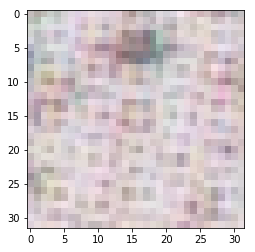

In [17]:
#Let's take a look at some of the data from the batch. 

item=10
plt.imshow(image[item, :, :, :])
if label[item]==1:
    print("This is part of a Vanh Gogh painting")
else:
    print("This is not part of a Vanh Gogh painting")



There are many things we could do to improve this accuracy. Can you name three?


In [ ]:
#Free our GPU memory before proceeding to the next part of the lab
import os
os._exit(00)

### References 
[1] From Impressionism to Expressionism: Automatically Identifying Van Gogh's Paintings", which has been published on the 23rd IEEE International Conference on Image Processing (ICIP 2016) 

[2] Pakhomov, Daniil. TFrecords Guide. December 21, 2016. http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

[3] Aymeric Damien. TensorFlow Examples, Neural Networks, ConvolutionalNetwork. https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb

[4] [TensorFlow Tutorial - Convolutional Neural Networks](https://www.tensorflow.org/tutorials/deep_cnn).